In [4]:
import pandas as pd

# Load data (replace with your dataset)
df = pd.read_csv('credit_default_payment.csv')
df.head(10)

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


In [5]:
df.drop(df.index[:1], inplace=True) 
df = df.rename(columns={'Unnamed: 0': 'ID'})
df = df.reset_index(drop=True)
list(df.columns)
#df.head()

# Check for missing values
print(df.isnull().sum()) # No missing values

# Fill missing values (if any)
#df.fillna(df.median(), inplace=True)  

ID     0
X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
Y      0
dtype: int64



Class Distribution:
Y
0    23364
1     6636
Name: count, dtype: int64


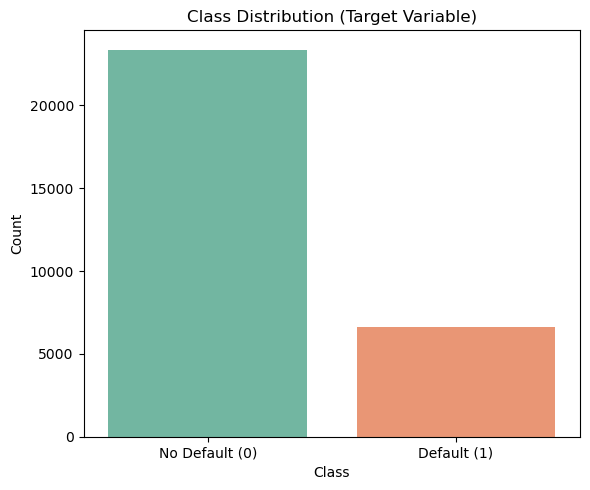


Imbalance Ratio (No Default / Default): 3.52
Imbalance Percentage: 55.76%


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Class Imbalance Visualization ---

# Check class distribution
target_col = 'Y'  # Replace with your target column if different
class_counts = df[target_col].value_counts()

print("\nClass Distribution:")
print(class_counts)

# Plot class imbalance
plt.figure(figsize=(6, 5))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values, palette='Set2')
plt.title('Class Distribution (Target Variable)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.tight_layout()
plt.show()

# Calculate and print imbalance ratio and percentage
Y_0 = class_counts.get(0, 0)
Y_1 = class_counts.get(1, 0)
total_count = len(df)
imbalance_ratio = Y_0 / Y_1 if Y_1 != 0 else float('inf')
imbalance_percentage = abs(Y_0 - Y_1) / total_count * 100

print(f"\nImbalance Ratio (No Default / Default): {imbalance_ratio:.2f}")
print(f"Imbalance Percentage: {imbalance_percentage:.2f}%")

## Logistic Regression

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, classification_report, recall_score, f1_score, roc_auc_score, confusion_matrix

In [8]:
# Preprocessing
# One-hot encode categorical variables
df_encoded_log = pd.get_dummies(df, columns=['X2', 'X3', 'X4'], drop_first=True)

In [9]:
# Define features and target
X_log = df_encoded_log.drop('Y', axis=1)  # All X1–X23 after encoding
y_log = df_encoded_log['Y'].astype(int)  # Target variable

In [10]:
# Split into train and test sets
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ['X1', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 
                  'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 
                  'X18', 'X19', 'X20', 'X21', 'X22', 'X23']

X_train_log[numerical_cols] = scaler.fit_transform(X_train_log[numerical_cols])
X_test_log[numerical_cols] = scaler.transform(X_test_log[numerical_cols])

In [11]:
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_log, y_train_log)

# Define Logistic Regression with class weights as an alternative
log_reg_balanced = LogisticRegression(class_weight='balanced', max_iter=20000)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'],      # Solvers compatible with class_weight
    'penalty': ['l2']                      # lbfgs supports only l2, liblinear supports l1/l2
}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=20000), 
                           param_grid, 
                           cv=5, 
                           scoring='roc_auc', 
                           n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

C:\Users\kapil\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=20000),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='roc_auc')

In [12]:
# Best model from GridSearchCV
best_log_reg = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score from CV:", grid_search.best_score_)

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best ROC-AUC Score from CV: 0.8837878168658552


In [13]:
# Predict on test set
y_pred_log = best_log_reg.predict(X_test_log)
y_pred_proba_log = best_log_reg.predict_proba(X_test_log)[:, 1]

In [ ]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test_log, y_pred_log))
print("ROC-AUC Score:", roc_auc_score(y_test_log, y_pred_proba_log))
print("Classification Report:\n", classification_report(y_test_log, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test_log, y_pred_log))

Accuracy: 0.8125
ROC-AUC Score: 0.7254306973754275
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.89      4687
           1       0.62      0.38      0.47      1313

    accuracy                           0.81      6000
   macro avg       0.73      0.66      0.68      6000
weighted avg       0.79      0.81      0.80      6000

Confusion Matrix:
 [[4375  312]
 [ 813  500]]


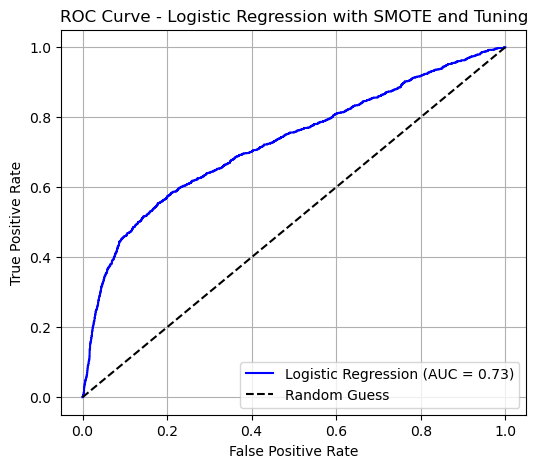

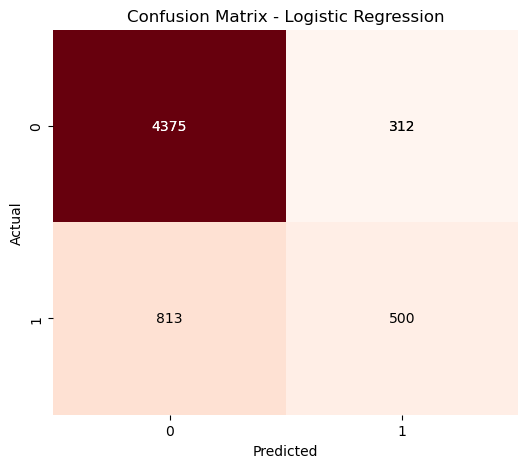

In [15]:
# Plot ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test_log, y_pred_proba_log)
roc_auc_log = auc(fpr_log, tpr_log)

plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, color='blue', label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with SMOTE and Tuning')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Colored Confusion Matrix with custom color and visible annotations
cm = confusion_matrix(y_test_log, y_pred_log)
plt.figure(figsize=(6, 5))
sns_heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)  # Changed to 'Reds'
# Adjust annotation color based on cell value
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = 'white' if value > cm.max() / 2 else 'black'  # White for dark cells, black for light
        sns_heatmap.text(j + 0.5, i + 0.5, value, ha='center', va='center', color=color)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['0', '1'])
plt.yticks([0.5, 1.5], ['0', '1'])
plt.show()

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
# Preprocessing
# One-hot encode categorical variables
df_encoded_rf = pd.get_dummies(df, columns=['X2', 'X3', 'X4'], drop_first=True)

# Define features and target
X_rf = df_encoded_rf.drop('Y', axis=1)
y_rf = df_encoded_rf['Y'].astype(int)

In [18]:
# Split into train and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42, stratify=y_rf)

In [19]:
# Standardize numerical features (optional for Random Forest, but can help)
scaler = StandardScaler()
numerical_cols = ['X1', 'X5'] + [f'X{i}' for i in range(6, 24)]
X_train_rf[numerical_cols] = scaler.fit_transform(X_train_rf[numerical_cols])
X_test_rf[numerical_cols] = scaler.transform(X_test_rf[numerical_cols])

In [20]:
# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_rf, y_train_rf)

In [21]:
# Define Random Forest with class weights as a baseline
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

In [22]:
# Hyperparameter tuning with GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],         # Number of trees
    'max_depth': [10, 20, None],        # Maximum depth of trees
    'min_samples_split': [2, 5],        # Minimum samples to split a node
    'max_features': ['log2', 'sqrt']    # Number of features to consider at each split
}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [23]:
# Best model from GridSearchCV
best_rf = grid_search_rf.best_estimator_
print("Best Parameters (Random Forest):", grid_search_rf.best_params_)
print("Best ROC-AUC Score from CV (Random Forest):", grid_search_rf.best_score_)

Best Parameters (Random Forest): {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200}
Best ROC-AUC Score from CV (Random Forest): 0.9343198647753708


In [24]:
#Predict on test set
y_pred_rf = best_rf.predict(X_test_rf)
y_pred_proba_rf = best_rf.predict_proba(X_test_rf)[:, 1]

In [ ]:
# Evaluate the model
print("Accuracy (Random Forest):", accuracy_score(y_test_rf, y_pred_rf))
print("ROC-AUC Score (Random Forest):", roc_auc_score(y_test_rf, y_pred_proba_rf))
print("Classification Report (Random Forest):\n", classification_report(y_test_rf, y_pred_rf))
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test_rf, y_pred_rf))

print(" ")

# Feature Importances
feature_importances_rf = pd.DataFrame({
    'Feature': X_train_rf.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Top 10 Feature Importances (Random Forest):\n", feature_importances_rf.head(10))

Accuracy (Random Forest): 0.814
ROC-AUC Score (Random Forest): 0.7617944545385789
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      4673
           1       0.62      0.40      0.49      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.67      0.69      6000
weighted avg       0.80      0.81      0.80      6000

Confusion Matrix (Random Forest):
 [[4353  320]
 [ 796  531]]
 
Top 10 Feature Importances (Random Forest):
    Feature  Importance
3       X6    0.158572
4       X7    0.086277
6       X9    0.071626
5       X8    0.069975
8      X11    0.051261
7      X10    0.046631
1       X1    0.032037
15     X18    0.031291
9      X12    0.031049
0       ID    0.030157


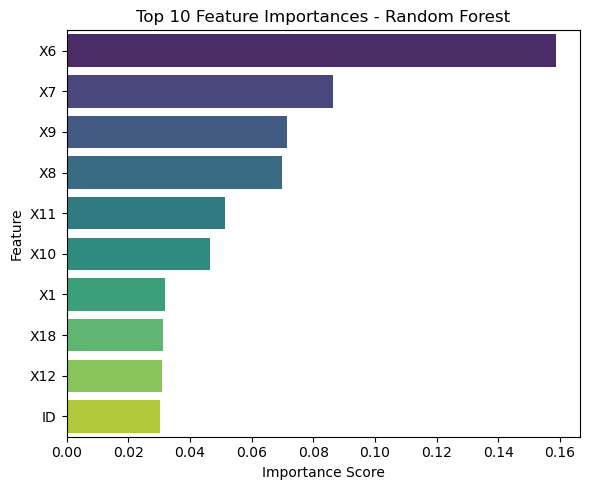

In [ ]:
# Sort and select top 10 important features
top_features = feature_importances_rf.head(10)

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

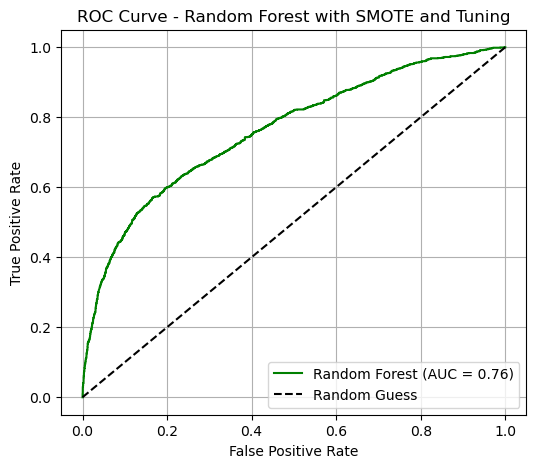

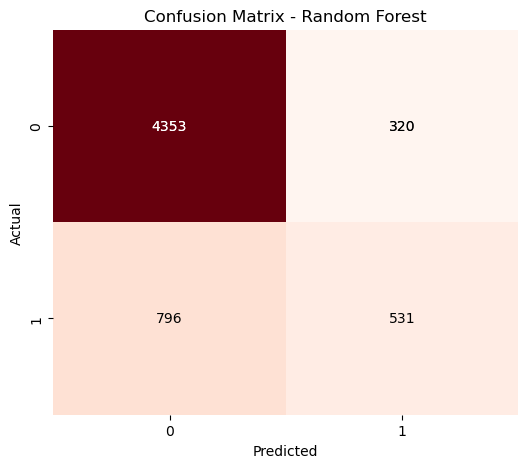

In [26]:
# Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest with SMOTE and Tuning')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Colored Confusion Matrix with custom color and visible annotations
cm = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(figsize=(6, 5))
sns_heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)  # Changed to 'Greens'
# Adjust annotation color based on cell value
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = 'white' if value > cm.max() / 2 else 'black'  # White for dark cells, black for light
        sns_heatmap.text(j + 0.5, i + 0.5, value, ha='center', va='center', color=color)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['0', '1'])
plt.yticks([0.5, 1.5], ['0', '1'])
plt.show()

## XGBoost

In [27]:
from xgboost import XGBClassifier

# Fix: Convert ID to integer
df['ID'] = df['ID'].astype(int)

# Convert object columns to float
numeric_cols = ['X1', 'X5'] + [f'X{i}' for i in range(6, 24)]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('float64')

# Fix: Convert target variable to integer
df['Y'] = df['Y'].astype(int)

# Preprocessing
# One-hot encode categorical variables
df_encoded_xg = pd.get_dummies(df, columns=['X2', 'X3', 'X4'], drop_first=True)

# Define features and target
X_xg = df_encoded_xg.drop('Y', axis=1)
y_xg = df_encoded_xg['Y']

# Verify data types
print("DataFrame dtypes:\n", X_xg.dtypes)  # Ensure all are int/float
print("Unique values in y:", y_xg.unique())  # Should be [0 1]

DataFrame dtypes:
 ID        int32
X1      float64
X5      float64
X6      float64
X7      float64
X8      float64
X9      float64
X10     float64
X11     float64
X12     float64
X13     float64
X14     float64
X15     float64
X16     float64
X17     float64
X18     float64
X19     float64
X20     float64
X21     float64
X22     float64
X23     float64
X2_2       bool
X3_1       bool
X3_2       bool
X3_3       bool
X3_4       bool
X3_5       bool
X3_6       bool
X4_1       bool
X4_2       bool
X4_3       bool
dtype: object
Unique values in y: [1 0]


In [28]:
# Split into train and test sets
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(X_xg, y_xg, test_size=0.2, random_state=42, stratify=y_xg)

# Standardize numerical features (optional for XGBoost)
scaler = StandardScaler()
numerical_cols = ['X1', 'X5'] + [f'X{i}' for i in range(6, 24)]
X_train_xg[numerical_cols] = scaler.fit_transform(X_train_xg[numerical_cols])
X_test_xg[numerical_cols] = scaler.transform(X_test_xg[numerical_cols])

In [29]:
#Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_xg, y_train_xg)

In [30]:
# Calculate scale_pos_weight for XGBoost (alternative to SMOTE)
scale_pos_weight = (y_train_xg.value_counts()[0] / y_train_xg.value_counts()[1])

In [31]:
# Define XGBoost with scale_pos_weight as a baseline
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)

In [32]:
# Hyperparameter tuning with GridSearchCV
param_grid_xgb = {
    'n_estimators': [100, 200],         # Number of trees
    'max_depth': [3, 6, 10],            # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinkage
    'subsample': [0.8, 1.0]             # Fraction of samples used per tree
}
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_xgb.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 10], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc')

In [33]:
# Best model from GridSearchCV
best_xgb = grid_search_xgb.best_estimator_
print("Best Parameters (XGBoost):", grid_search_xgb.best_params_)
print("Best ROC-AUC Score from CV (XGBoost):", grid_search_xgb.best_score_)

Best Parameters (XGBoost): {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Best ROC-AUC Score from CV (XGBoost): 0.9335435892159291


In [34]:
# Predict on test set
y_pred_xgb = best_xgb.predict(X_test_xg)
y_pred_proba_xgb = best_xgb.predict_proba(X_test_xg)[:, 1]

In [35]:
# Evaluate the model
print("Accuracy (XGBoost):", accuracy_score(y_test_xg, y_pred_xgb))
print("ROC-AUC Score (XGBoost):", roc_auc_score(y_test_xg, y_pred_proba_xgb))
print("Classification Report (XGBoost):\n", classification_report(y_test_xg, y_pred_xgb))
print("Confusion Matrix (XGBoost):\n", confusion_matrix(y_test_xg, y_pred_xgb))

print(" ")


# Feature Importances
feature_importances_xgb = pd.DataFrame({
    'Feature': X_train_xg.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Top 10 Feature Importances (XGBoost):\n", feature_importances_xgb.head(10))

Accuracy (XGBoost): 0.785
ROC-AUC Score (XGBoost): 0.754315262637696
Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      4673
           1       0.51      0.49      0.50      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.68      0.68      6000
weighted avg       0.78      0.79      0.78      6000

Confusion Matrix (XGBoost):
 [[4060  613]
 [ 677  650]]
 
Top 10 Feature Importances (XGBoost):
    Feature  Importance
3       X6    0.250710
29    X4_2    0.104098
5       X8    0.053930
22    X3_1    0.050647
6       X9    0.049051
8      X11    0.046471
4       X7    0.039126
7      X10    0.038608
24    X3_3    0.036923
28    X4_1    0.027916


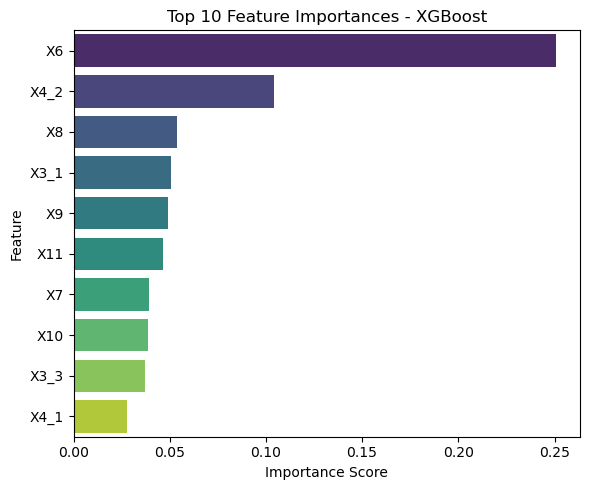

In [ ]:
# Sort and select top 10 important features
top_features = feature_importances_xgb.head(10)

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

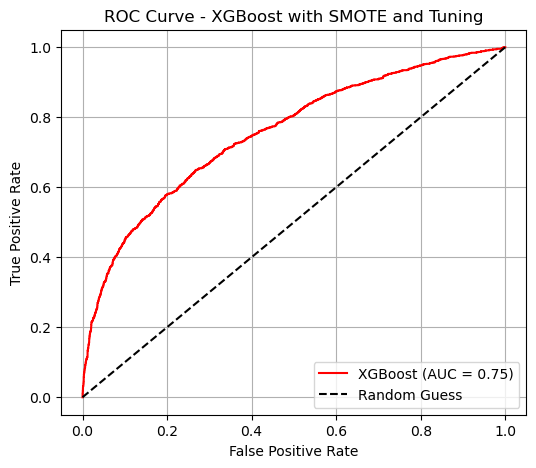

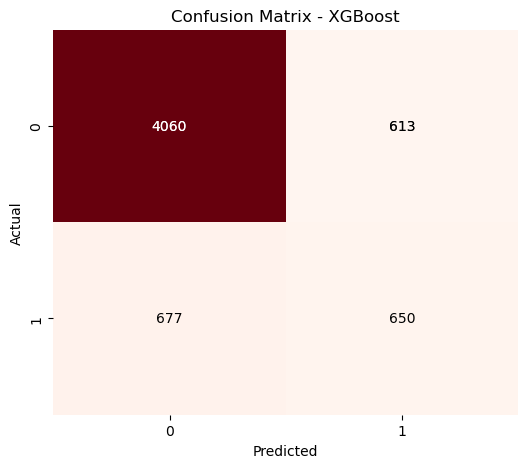

In [ ]:
# Plot ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_xg, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, color='red', label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost with SMOTE and Tuning')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Colored Confusion Matrix with custom color and visible annotations
cm = confusion_matrix(y_test_xg, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns_heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)  # Changed to 'Greens'
# Adjust annotation color based on cell value
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = 'white' if value > cm.max() / 2 else 'black'  # White for dark cells, black for light
        sns_heatmap.text(j + 0.5, i + 0.5, value, ha='center', va='center', color=color)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['0', '1'])
plt.yticks([0.5, 1.5], ['0', '1'])
plt.show()

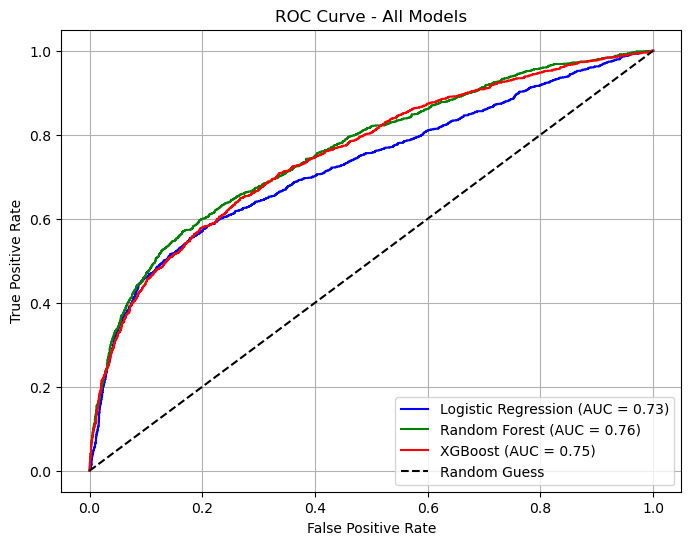

In [46]:
# Code for combined ROC curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc  

# Get ROC curve data for each model
fpr_log, tpr_log, _ = roc_curve(y_test_log, y_pred_proba_log)
roc_auc_log = auc(fpr_log, tpr_log)
fpr_ran, tpr_ran, _ = roc_curve(y_test_rf, y_pred_proba_rf)
roc_auc_ran = auc(fpr_ran, tpr_ran)
fpr_xg, tpr_xg, _ = roc_curve(y_test_xg, y_pred_proba_xgb)
roc_auc_xg = auc(fpr_xg, tpr_xg)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_ran, tpr_ran, color='green', label=f'Random Forest (AUC = {roc_auc_ran:.2f})')
plt.plot(fpr_xg, tpr_xg, color='red', label=f'XGBoost (AUC = {roc_auc_xg:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

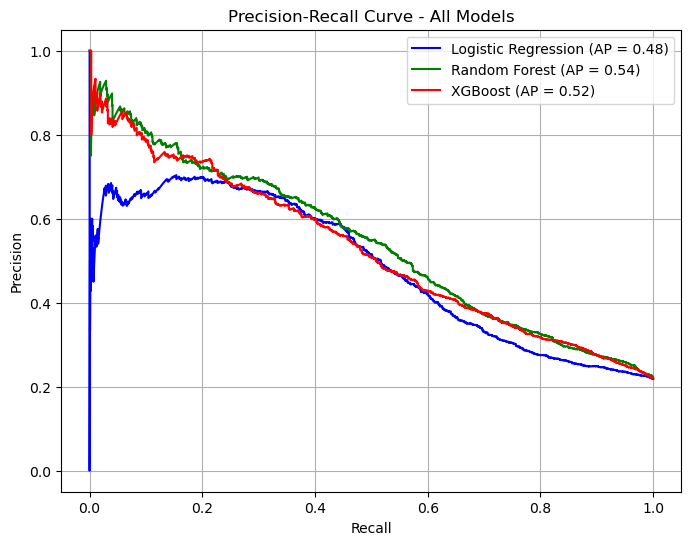

In [ ]:
# Code for combined Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall curve and average precision (AUC-PR) for each model
precision_log, recall_log, _ = precision_recall_curve(y_test_log, y_pred_proba_log)
ap_log = average_precision_score(y_test_log, y_pred_proba_log)

precision_rf, recall_rf, _ = precision_recall_curve(y_test_rf, y_pred_proba_rf)
ap_rf = average_precision_score(y_test_rf, y_pred_proba_rf)

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test_xg, y_pred_proba_xgb)
ap_xgb = average_precision_score(y_test_xg, y_pred_proba_xgb)

# Plot Precision-Recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_log, precision_log, label=f'Logistic Regression (AP = {ap_log:.2f})', color='blue')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {ap_rf:.2f})', color='green')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f})', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - All Models')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()